# DCGANs Tutorial

One of the most interesting parts of Generative Adversarial Networks is the design of the Generator network. The Generator network is able to take random noise and map it into images such that the discriminator cannot tell which images came from the dataset and which images came from the generator.

Let's start with importing the required libraries

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
import plot_utils
from tqdm import tqdm

%matplotlib inline

print("Tensorflow version : " ,tf.__version__ )

Tensorflow version :  2.2.0


### Load the data and preprocess the data

- Keras has in built data set called **mnist** dataset.
- After loading the datasets, we need to preprocess the pictures in the dataset. This makes the training easier

In [ ]:
# Loading the data
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()

x_train = x_train.astype(np.float32)/255.0
x_test = x_test.astype(np.float32)/255.0

#### Getting brief details of the data set

In [ ]:
# Shape of data

print("Shape of x_train = ", x_train.shape)
print("Shape of y_train = ", y_train.shape)
print("Shape of x_test = ", x_test.shape)
print("Shape of y_test = ", y_test.shape)

assert(x_train.shape[0] == y_train.shape[0])
assert(x_test.shape[0] == y_test.shape[0])

Shape of x_train =  (60000, 28, 28)
Shape of y_train =  (60000,)
Shape of x_test =  (10000, 28, 28)
Shape of y_test =  (10000,)


#### Visualizing a small sample of the data set

We use subplots to achieve this

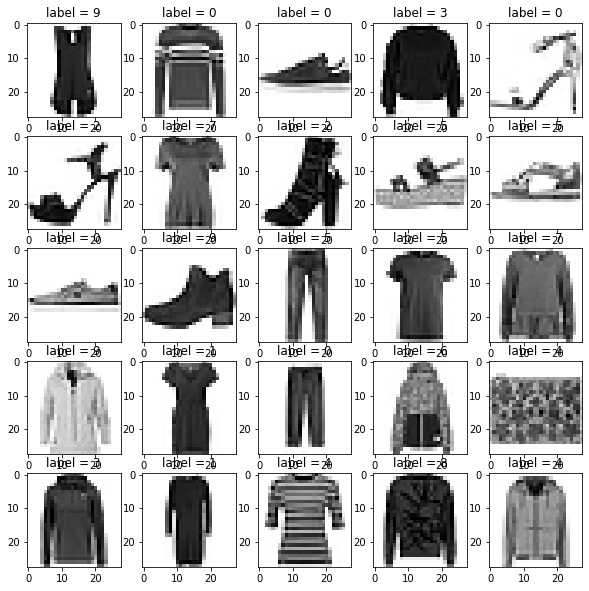

In [ ]:
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.title("label = " + str(y_train[i]))
    #plt.grid(True)
    plt.imshow(x_train[i+4], cmap = plt.cm.binary)

### Creating Batches of training data

In [ ]:
batch_size = 32
dataset = tf.data.Dataset.from_tensor_slices(x_train).shuffle(1000)


#### What does the above function do?

It creates a buffer tensor of size 1000 and fills it with 1000 elements and randomly samples the elements from this buffer into the data set

Let's create the batches now.<br>
Creating batches is easy with tensorflow. It has a dedicaited method for this purpose. 

In [ ]:
dataset = dataset.batch(batch_size,
                        drop_remainder = True).prefetch(1)

### Build the Generator Network for DCGAN

<img src="./src/Training-schematic-for-DCGAN-The-generator-G-takes-samples-from-the-normal.png" style="width:450;height:300px;">
<br>
<br>
<caption><center> <bold>Figure 1</bold> : Schematic diagram of working of GANs.  </center></caption>

- **G -> Generator** is an upsampling network with fractionally-strided convolutions.

- **D -> Discriminator** is a convolutional network too.

The Generator network is able to take random noise and map it into images such that the discriminator cannot tell which images came from the dataset and which images came from the generator.

Architecture for stable *Deep Convolutional GANs* :

- Replace any **pooling layers** with **strided convolutions** (discriminator) and **frctional-strided convolutions** (generator).
- Use **BatchNorm** in both generator and discriminator.
- Use **ReLU** activation in generator for all the layers except for the output, which uses **tanh**.
- Use **LeakyReLU** activation in the discriminator for all the layers except the output layer, which use **sigmoid** for the binary classification.
- In few papers, it was recommended to use **SELU** activation function for faster convergence. But, if you use SELU without a BatchNorm preceeding it, it may lead to gradient explosion and other problems.

<font color = 'darkblue'>selu( x. The Scaled Exponential Linear Unit (SELU) activation function is: scale * x if x > 0 and scale * alpha * (exp(x) - 1) if x < 0 where alpha and scale are pre-defined constants ( alpha = 1.67326324 and scale = 1.05070098 )</font>


[Source](https://arxiv.org/pdf/1511.06434.pdf) : Radford er al, "*Unsupervised Representation Learning with Deep Convolutional Generative Adversial Networks*", ICLR 2016



#### Building the generator network using the Sequential() API of *keras*

In [ ]:
num_features = 100

generator = keras.models.Sequential()

#### Add the layers to our model

In [ ]:
generator.add(keras.layers.Dense(7*7*128, input_shape = [num_features]))
generator.add(keras.layers.Reshape([7,7,128]))
generator.add(keras.layers.BatchNormalization())
generator.add(keras.layers.Conv2DTranspose(64, (5,5), (2,2), padding = 'same', activation = 'selu'))
generator.add(keras.layers.BatchNormalization())
generator.add(keras.layers.Conv2DTranspose(1, (5,5), (2,2), padding = 'same', activation = 'tanh'))


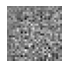

In [ ]:
noise = tf.random.normal(shape = [1,num_features])
generated_image = generator(noise, training = False)
plot_utils.show(generated_image, 1)

### Building a discriminator network

Discriminator is a CNN based image classifier.<br>
In this case, the discriminator is a binary image classifier.

In [ ]:
discriminator = keras.models.Sequential()

discriminator.add(keras.layers.Conv2D(64, (5,5), (2,2), padding = 'same', input_shape = [28,28,1]))
discriminator.add(keras.layers.LeakyReLU(0.2))
discriminator.add(keras.layers.Dropout(0.3))
discriminator.add(keras.layers.Conv2D(128, (5,5), (2,2), padding = 'same'))
discriminator.add(keras.layers.LeakyReLU(0.2))
discriminator.add(keras.layers.Dropout(0.3))
discriminator.add(keras.layers.Flatten())
discriminator.add(keras.layers.Dense(1, activation = 'sigmoid'))


In [ ]:
decision = discriminator(generated_image)
print(decision)

tf.Tensor([[0.50113314]], shape=(1, 1), dtype=float32)


### Compile the Deep Convolutional Generative Adversial Network (DCGAN)

In [ ]:
discriminator.compile(loss = 'binary_crossentropy', optimizer = 'rmsprop')
discriminator.trainable = False

gan = keras.models.Sequential([generator, discriminator])
gan.compile(loss = 'binary_crossentropy', optimizer = 'rmsprop')


Choosing an appropriate optimizing algorithm for training the DCGAN is also an open research area.

### Define the Training Procedure

We first train **D** and then train **G** such that it maximizes the probability that **D** clasiifies the generated image as real.

In [ ]:
seed = tf.random.normal(shape = [batch_size, 100])


#### The Training procedure

In each epoch, we are going to train the discriminator a bit and then train the generator. 
For this, we are going to sample a small sample of data using our **G** and then concat this generated sample with a batch of training set. The labels will be generated in each epoch. Labels are, 0 for generated and 1 for those from training set. We will train **D** with this mixed data and update the parameters.
Now, we will train the **gan** model with **D**.trainable set to `False`. This trians **G** to fool **D** such that generated images are recognised as *Real*. To achieve this, we set the labels to 1 for generated images.  

So, this process is alternated. First we train **D** to learn to recognise which is real, and then **G** is trained to fool **D**


**tqdm** is the package that adds progress bars for epochs.
You can get a progress bar for any iterable by wrapping it with `tqdm()`

In [ ]:
def train_dcgan(gan, dataset, batch_size, num_features, epochs):
    generator, discriminator = gan.layers
    for epoch in range(epochs):
        print('Epochs {}/{} \n'.format(epoch+1, epochs))
        batch_num = 1
        for x_batch in dataset:
            print('Training on batch : '  + str(batch_num) + ', in the epoch' + str(epoch) + '\n')
            noise = tf.random.normal(shape = [batch_size, num_features])
            generated_images = generator(noise)
            x_fake_and_real = tf.concat([generated_images, x_batch], axis = 0)
            y1 = tf.constant([[0.]]*batch_size + [[1.]]*batch_size)
            discriminator.trainable = True
            discriminator.train_on_batch(x_fake_and_real, y1)
            discriminator.trainable = False
            y2 = tf.constant([[1.]]*batch_size)
            gan.train_on_batch(noise, y2)
            batch_num += 1
        print('-'*100)
        print("Entering next epoch\n")
    print('Completed training successfully!!')

### Train DCGAN

In [ ]:
x_train_dcgan = x_train.reshape(-1, 28, 28, 1) *2. -1.

In [ ]:
batch_size = 32
dataset = tf.data.Dataset.from_tensor_slices(x_train_dcgan).shuffle(1000)
dataset = dataset.batch(batch_size, drop_remainder = True).prefetch(1)

In [ ]:
%%time
print(tf.executing_eagerly())
train_dcgan(gan, dataset, batch_size, num_features, epochs = 10)

Streaming output truncated to the last 5000 lines.
Training on batch : 1257, in the epoch8

Training on batch : 1258, in the epoch8

Training on batch : 1259, in the epoch8

Training on batch : 1260, in the epoch8

Training on batch : 1261, in the epoch8

Training on batch : 1262, in the epoch8

Training on batch : 1263, in the epoch8

Training on batch : 1264, in the epoch8

Training on batch : 1265, in the epoch8

Training on batch : 1266, in the epoch8

Training on batch : 1267, in the epoch8

Training on batch : 1268, in the epoch8

Training on batch : 1269, in the epoch8

Training on batch : 1270, in the epoch8

Training on batch : 1271, in the epoch8

Training on batch : 1272, in the epoch8

Training on batch : 1273, in the epoch8

Training on batch : 1274, in the epoch8

Training on batch : 1275, in the epoch8

Training on batch : 1276, in the epoch8

Training on batch : 1277, in the epoch8

Training on batch : 1278, in the epoch8

Training on batch : 1279, in the epoch8

Traini

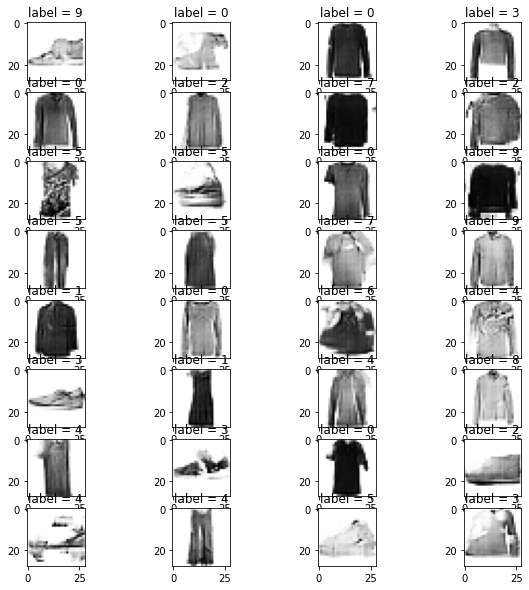

In [ ]:
noise = tf.random.normal([batch_size, num_features])
generated_images = generator(noise, training = False)
#plot_utils.show(generated_images, 8)
plt.figure(figsize=(10,10))
for i in range(32):
    plt.subplot(8,4,i+1)
    plt.title("label = " + str(y_train[i]))
    #plt.grid(True)
    plt.imshow(generated_images[i,:,:,0], cmap = plt.cm.binary)

The above images were generated by the **G** of the DCGAN we have built.

The performance can be improved by using larger number of epochs.

Now let's save our **G**, **D** and **gan** models

In [ ]:
gan.save("dcgan.h5")
generator.save("generator.h5")
discriminator.save("discriminator.h5")

In [ ]:
imported_model = keras.models.load_model('generator.h5')

In [ ]:
noise = tf.random.normal([batch_size, num_features])
new_clothes = imported_model(noise, training = False)

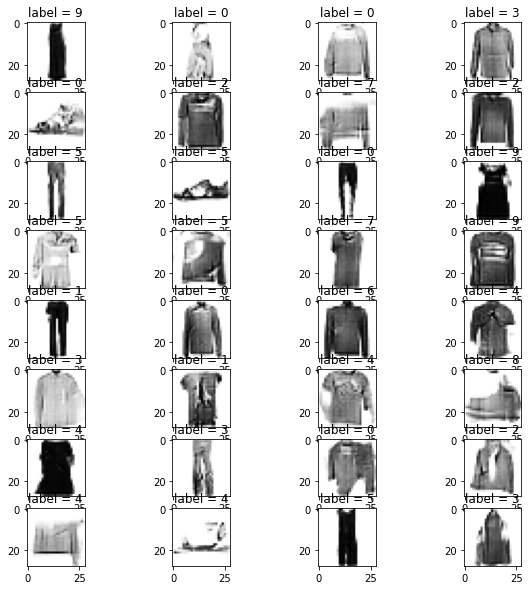

In [ ]:
plt.figure(figsize=(10,10))
for i in range(32):
    plt.subplot(8,4,i+1)
    plt.title("label = " + str(y_train[i]))
    #plt.grid(True)
    plt.imshow(new_clothes[i,:,:,0], cmap = plt.cm.binary)